# exp22: 冗長な特徴量の削減 + Optuna再最適化

**ベースライン**: exp21 (Holdout Validation)

**背景**:
- exp21で特徴量の相関分析を実施
- 多くの冗長な特徴量ペアを発見

**削減方針**:
1. `woy` → `week_of_year` に統一（一般的に分かりやすい）
2. `days_from_start`, `days_to_2019_09_30` 削除 → `days_to_2019_10_01` のみ残す（PoC向け）
3. `is_pre_*` 削除 → `is_post_*` のみ残す（pre = 1 - post で表現可能）
4. `quarter`, `month` 削除 → `day_of_year` のみ残す（季節性の高粒度表現）
5. `wom` 削除 → `day_of_month` を残す（CatBoostで強い）
6. `acc_get_lag7`, `acc_get_sum_14d` 削除 → `acc_ma_7` のみ残す（滑らかで扱いやすい）
7. `ma_14`, `ma_std_14` 削除 → `ma_7`, `ma_std_7` を残す（短期が強い）
8. `ma_30`, `ma_std_30` は両方残す（平均とばらつきは意味が異なる）

**特徴量数**: 50 → 37（13個削減）

**実験内容**:
1. 削減後の特徴量でベースライン評価
2. Optunaで各モデルを再最適化
3. exp21との比較

In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')
import os

# 出力ディレクトリ
output_dir = '../output/exp22'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [7]:
# ==================================================================================
# データの読み込みと特徴量作成（exp21と同じ）
# ==================================================================================

def load_and_preprocess_data():
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

def create_acc_get_features(df):
    df = df.copy()
    df['acc_get_lag7'] = df['acc_get_cnt'].shift(7)
    df['acc_get_sum_14d'] = df['acc_get_cnt'].shift(1).rolling(window=14, min_periods=1).sum()
    return df

def create_regime_change_features(df):
    df = df.copy()
    
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_pre_2019_10_01'] = (df['cdr_date'] < tax_implementation_date).astype(int)
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    
    df['days_to_2019_09_30'] = (rush_deadline - df['cdr_date']).dt.days
    df['is_pre_2019_09_30'] = (df['cdr_date'] < rush_deadline).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    return df

print('データ読み込み・特徴量作成関数を定義しました')

データ読み込み・特徴量作成関数を定義しました


In [8]:
# ==================================================================================
# データ準備
# ==================================================================================

print("*" * 80)
print("exp22: 冗長な特徴量の削減 + Optuna再最適化")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)
df = create_acc_get_features(df)
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")

********************************************************************************
exp22: 冗長な特徴量の削減 + Optuna再最適化
********************************************************************************

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [9]:
# ==================================================================================
# 特徴量の削減（exp21分析結果に基づく）
# ==================================================================================

print("\n" + "=" * 80)
print("特徴量の削減")
print("=" * 80)

# exp21の特徴量（50個）
feature_cols_exp21 = [
    'dow', 'day_of_month', 'month', 'quarter', 'year', 
    'days_from_start', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    'woy', 'wom', 'day_before_holiday_flag',
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    'ma_3', 'ma_7', 'ma_14', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30',
    'days_to_2019_10_01', 'is_pre_2019_10_01', 'is_post_2019_10_01',
    'days_to_2019_09_30', 'is_pre_2019_09_30', 'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
    'acc_get_lag7', 'acc_get_sum_14d'
]

# 削除する特徴量
features_to_remove = [
    'woy',                  # グループ1: week_of_yearに統一
    'days_from_start',      # グループ2: days_to_2019_10_01のみ残す
    'days_to_2019_09_30',   # グループ2: days_to_2019_10_01のみ残す
    'is_pre_2019_10_01',    # グループ3: is_post_*のみ残す
    'is_pre_2019_09_30',    # グループ4: is_post_*のみ残す
    'quarter',              # グループ5: day_of_yearのみ残す
    'month',                # グループ5: day_of_yearのみ残す
    'wom',                  # グループ6: day_of_monthを残す
    'acc_get_lag7',         # グループ7: acc_ma_7のみ残す
    'acc_get_sum_14d',      # グループ7: acc_ma_7のみ残す
    'ma_14',                # グループ9: ma_7, ma_std_7を残す
    'ma_std_14',            # グループ9: ma_7, ma_std_7を残す
]

# exp22の特徴量（37個）
feature_cols_exp22 = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'year', 
    'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量（ma_14, ma_std_14削除）
    'ma_3', 'ma_7', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_30',
    # レジーム変化特徴量（is_pre_*削除、days_to_2019_09_30削除）
    'days_to_2019_10_01', 'is_post_2019_10_01',
    'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
]

print(f"\nexp21の特徴量数: {len(feature_cols_exp21)}")
print(f"削除する特徴量数: {len(features_to_remove)}")
print(f"exp22の特徴量数: {len(feature_cols_exp22)}")

print("\n【削除する特徴量】")
for feat in features_to_remove:
    print(f"  - {feat}")

print("\n【exp22で使用する特徴量】")
for i, feat in enumerate(feature_cols_exp22, 1):
    print(f"  {i:2d}. {feat}")


特徴量の削減

exp21の特徴量数: 45
削除する特徴量数: 12
exp22の特徴量数: 33

【削除する特徴量】
  - woy
  - days_from_start
  - days_to_2019_09_30
  - is_pre_2019_10_01
  - is_pre_2019_09_30
  - quarter
  - month
  - wom
  - acc_get_lag7
  - acc_get_sum_14d
  - ma_14
  - ma_std_14

【exp22で使用する特徴量】
   1. dow
   2. day_of_month
   3. year
   4. day_of_year
   5. week_of_year
   6. is_month_start
   7. is_month_end
   8. day_before_holiday_flag
   9. cm_flg
  10. acc_get_cnt
  11. search_cnt
  12. cm_7d
  13. gt_ma_7
  14. acc_ma_7
  15. dow_avg
  16. lag_1
  17. lag_2
  18. lag_3
  19. lag_5
  20. lag_7
  21. lag_14
  22. lag_30
  23. ma_3
  24. ma_7
  25. ma_30
  26. ma_std_3
  27. ma_std_7
  28. ma_std_30
  29. days_to_2019_10_01
  30. is_post_2019_10_01
  31. is_post_2019_09_30
  32. is_rush_period
  33. is_adaptation_period


In [10]:
# ==================================================================================
# Holdout Validation 設定（exp21と同じ）
# ==================================================================================

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols_exp22 + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("Holdout Validation 設定")
print("=" * 80)

# Holdout分割
test_start_date = pd.Timestamp('2020-01-30')
train_end_date = test_start_date - pd.Timedelta(days=1)

train_df = df_clean[df_clean['cdr_date'] <= train_end_date].copy()
test_df = df_clean[df_clean['cdr_date'] >= test_start_date].copy()

X_train = train_df[feature_cols_exp22]
y_train = train_df['target_next_day']
X_test = test_df[feature_cols_exp22]
y_test = test_df['target_next_day']

print(f"\nTrain: {len(X_train)}件 ({train_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {train_df['cdr_date'].max().strftime('%Y-%m-%d')})")
print(f"Test : {len(X_test)}件 ({test_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {test_df['cdr_date'].max().strftime('%Y-%m-%d')})")


Holdout Validation 設定

Train: 413件 (2018-07-02 ~ 2020-01-29)
Test : 43件 (2020-01-30 ~ 2020-03-30)


In [11]:
# ==================================================================================
# 評価関数
# ==================================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


---

# Step 1: exp19パラメータでのベースライン（特徴量削減のみ）

In [12]:
# ==================================================================================
# exp19パラメータでのベースライン評価
# ==================================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from scipy.optimize import minimize

OPTIMIZED_PARAMS_EXP19 = {
    'Ridge': {'alpha': 16.450548234070856},
    'ExtraTrees': {
        'n_estimators': 472,
        'max_depth': 35,
        'min_samples_split': 15,
        'min_samples_leaf': 4,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 465,
        'learning_rate': 0.02173701290406704,
        'max_depth': 22,
        'min_samples_leaf': 17,
        'l2_regularization': 11.071266395457282
    },
    'CatBoost': {
        'iterations': 2099,
        'learning_rate': 0.04211275181711693,
        'depth': 9,
        'l2_leaf_reg': 3.7647684179184813,
        'subsample': 0.9533426254881911
    }
}

print("\n" + "=" * 80)
print("Step 1: exp19パラメータでのベースライン（特徴量削減のみ）")
print("=" * 80)

baseline_results = []
baseline_predictions = {}
baseline_models = {}

# 1. Ridge
print("\n[1/4] Ridge...")
ridge_model = Ridge(**OPTIMIZED_PARAMS_EXP19['Ridge'], random_state=42)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_metrics = evaluate_model(y_test, ridge_pred)
print(f"  MAE: {ridge_metrics['MAE']:.2f}")
baseline_predictions['Ridge'] = ridge_pred
baseline_models['Ridge'] = ridge_model
baseline_results.append({'model': 'Ridge', **ridge_metrics})

# 2. ExtraTrees
print("\n[2/4] ExtraTrees...")
extra_model = ExtraTreesRegressor(**OPTIMIZED_PARAMS_EXP19['ExtraTrees'], random_state=42, n_jobs=-1)
extra_model.fit(X_train, y_train)
extra_pred = extra_model.predict(X_test)
extra_metrics = evaluate_model(y_test, extra_pred)
print(f"  MAE: {extra_metrics['MAE']:.2f}")
baseline_predictions['ExtraTrees'] = extra_pred
baseline_models['ExtraTrees'] = extra_model
baseline_results.append({'model': 'ExtraTrees', **extra_metrics})

# 3. HistGradientBoosting
print("\n[3/4] HistGradientBoosting...")
hist_model = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS_EXP19['HistGradientBoosting'], random_state=42)
hist_model.fit(X_train, y_train)
hist_pred = hist_model.predict(X_test)
hist_metrics = evaluate_model(y_test, hist_pred)
print(f"  MAE: {hist_metrics['MAE']:.2f}")
baseline_predictions['HistGradientBoosting'] = hist_pred
baseline_models['HistGradientBoosting'] = hist_model
baseline_results.append({'model': 'HistGradientBoosting', **hist_metrics})

# 4. CatBoost
print("\n[4/4] CatBoost...")
catboost_model = CatBoostRegressor(**OPTIMIZED_PARAMS_EXP19['CatBoost'], random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)
catboost_metrics = evaluate_model(y_test, catboost_pred)
print(f"  MAE: {catboost_metrics['MAE']:.2f}")
baseline_predictions['CatBoost'] = catboost_pred
baseline_models['CatBoost'] = catboost_model
baseline_results.append({'model': 'CatBoost', **catboost_metrics})

baseline_df = pd.DataFrame(baseline_results).sort_values('MAE')
print("\n" + "=" * 80)
print("ベースライン結果（exp19パラメータ + 特徴量削減）")
print("=" * 80)
print(baseline_df.to_string(index=False))


Step 1: exp19パラメータでのベースライン（特徴量削減のみ）

[1/4] Ridge...
  MAE: 22.02

[2/4] ExtraTrees...
  MAE: 16.00

[3/4] HistGradientBoosting...
  MAE: 30.26

[4/4] CatBoost...
  MAE: 28.29

ベースライン結果（exp19パラメータ + 特徴量削減）
               model       MAE      RMSE       R2      WAPE
          ExtraTrees 15.997629 21.429342 0.868225 16.676316
               Ridge 22.015766 27.412441 0.784369 22.949768
            CatBoost 28.294153 34.454930 0.659343 29.494511
HistGradientBoosting 30.257007 36.498703 0.617730 31.540637


---

# Step 2: Optunaによる再最適化

In [13]:
# ==================================================================================
# Optuna による再最適化
# ==================================================================================

import optuna
from sklearn.model_selection import TimeSeriesSplit

optuna.logging.set_verbosity(optuna.logging.WARNING)

# TimeSeriesCV（3分割）
tscv = TimeSeriesSplit(n_splits=3)

print("\n" + "=" * 80)
print("Step 2: Optunaによる再最適化")
print("=" * 80)
print("\n各モデル100トライアル、TimeSeriesCV(n_splits=3)で評価")


Step 2: Optunaによる再最適化

各モデル100トライアル、TimeSeriesCV(n_splits=3)で評価


In [14]:
# ==================================================================================
# Ridge 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[1/4] Ridge 最適化")
print("-" * 60)

def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 0.01, 100.0, log=True)
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = Ridge(alpha=alpha, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_ridge = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_ridge.optimize(objective_ridge, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_ridge.best_value:.2f}")
print(f"Best params: {study_ridge.best_params}")


------------------------------------------------------------
[1/4] Ridge 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 101.87
Best params: {'alpha': 0.33687714881527253}


In [15]:
# ==================================================================================
# ExtraTrees 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[2/4] ExtraTrees 最適化")
print("-" * 60)

def objective_extra(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = ExtraTreesRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_extra = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_extra.optimize(objective_extra, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_extra.best_value:.2f}")
print(f"Best params: {study_extra.best_params}")


------------------------------------------------------------
[2/4] ExtraTrees 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 52.50
Best params: {'n_estimators': 274, 'max_depth': 11, 'min_samples_split': 29, 'min_samples_leaf': 4, 'max_features': None}


In [16]:
# ==================================================================================
# HistGradientBoosting 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[3/4] HistGradientBoosting 最適化")
print("-" * 60)

def objective_hist(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.01, 50.0, log=True),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = HistGradientBoostingRegressor(**params, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_hist = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_hist.optimize(objective_hist, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_hist.best_value:.2f}")
print(f"Best params: {study_hist.best_params}")


------------------------------------------------------------
[3/4] HistGradientBoosting 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 48.55
Best params: {'max_iter': 183, 'learning_rate': 0.018120547421615427, 'max_depth': 30, 'min_samples_leaf': 6, 'l2_regularization': 0.022360855923847303}


In [17]:
# ==================================================================================
# CatBoost 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[4/4] CatBoost 最適化")
print("-" * 60)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = CatBoostRegressor(**params, random_state=42, verbose=0)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_catboost = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_catboost.optimize(objective_catboost, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_catboost.best_value:.2f}")
print(f"Best params: {study_catboost.best_params}")


------------------------------------------------------------
[4/4] CatBoost 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 51.02
Best params: {'iterations': 1547, 'learning_rate': 0.04313835983436318, 'depth': 4, 'l2_leaf_reg': 0.13964878723609409, 'subsample': 0.8418882107293159}


In [18]:
# ==================================================================================
# 最適化されたパラメータの保存
# ==================================================================================

OPTIMIZED_PARAMS_EXP22 = {
    'Ridge': study_ridge.best_params,
    'ExtraTrees': study_extra.best_params,
    'HistGradientBoosting': study_hist.best_params,
    'CatBoost': study_catboost.best_params,
}

print("\n" + "=" * 80)
print("exp22 最適化パラメータ")
print("=" * 80)
for model_name, params in OPTIMIZED_PARAMS_EXP22.items():
    print(f"\n{model_name}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

# パラメータをCSVに保存
params_list = []
for model_name, params in OPTIMIZED_PARAMS_EXP22.items():
    for key, value in params.items():
        params_list.append({'model': model_name, 'param': key, 'value': value})

params_df = pd.DataFrame(params_list)
params_df.to_csv(f'{output_dir}/optimized_params.csv', index=False)
print(f"\nパラメータを保存しました: {output_dir}/optimized_params.csv")


exp22 最適化パラメータ

Ridge:
  alpha: 0.33687714881527253

ExtraTrees:
  n_estimators: 274
  max_depth: 11
  min_samples_split: 29
  min_samples_leaf: 4
  max_features: None

HistGradientBoosting:
  max_iter: 183
  learning_rate: 0.018120547421615427
  max_depth: 30
  min_samples_leaf: 6
  l2_regularization: 0.022360855923847303

CatBoost:
  iterations: 1547
  learning_rate: 0.04313835983436318
  depth: 4
  l2_leaf_reg: 0.13964878723609409
  subsample: 0.8418882107293159

パラメータを保存しました: ../output/exp22/optimized_params.csv


---

# Step 3: 最適化パラメータでの最終評価

In [19]:
# ==================================================================================
# 最適化パラメータでの最終評価
# ==================================================================================

print("\n" + "=" * 80)
print("Step 3: 最適化パラメータでの最終評価（Holdout Test）")
print("=" * 80)

final_results = []
final_predictions = {}
final_models = {}

# 1. Ridge
print("\n[1/4] Ridge...")
ridge_opt = Ridge(**OPTIMIZED_PARAMS_EXP22['Ridge'], random_state=42)
ridge_opt.fit(X_train, y_train)
ridge_pred_opt = ridge_opt.predict(X_test)
ridge_metrics_opt = evaluate_model(y_test, ridge_pred_opt)
print(f"  MAE: {ridge_metrics_opt['MAE']:.2f}")
final_predictions['Ridge'] = ridge_pred_opt
final_models['Ridge'] = ridge_opt
final_results.append({'model': 'Ridge', **ridge_metrics_opt})

# 2. ExtraTrees
print("\n[2/4] ExtraTrees...")
extra_opt = ExtraTreesRegressor(**OPTIMIZED_PARAMS_EXP22['ExtraTrees'], random_state=42, n_jobs=-1)
extra_opt.fit(X_train, y_train)
extra_pred_opt = extra_opt.predict(X_test)
extra_metrics_opt = evaluate_model(y_test, extra_pred_opt)
print(f"  MAE: {extra_metrics_opt['MAE']:.2f}")
final_predictions['ExtraTrees'] = extra_pred_opt
final_models['ExtraTrees'] = extra_opt
final_results.append({'model': 'ExtraTrees', **extra_metrics_opt})

# 3. HistGradientBoosting
print("\n[3/4] HistGradientBoosting...")
hist_opt = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS_EXP22['HistGradientBoosting'], random_state=42)
hist_opt.fit(X_train, y_train)
hist_pred_opt = hist_opt.predict(X_test)
hist_metrics_opt = evaluate_model(y_test, hist_pred_opt)
print(f"  MAE: {hist_metrics_opt['MAE']:.2f}")
final_predictions['HistGradientBoosting'] = hist_pred_opt
final_models['HistGradientBoosting'] = hist_opt
final_results.append({'model': 'HistGradientBoosting', **hist_metrics_opt})

# 4. CatBoost
print("\n[4/4] CatBoost...")
catboost_opt = CatBoostRegressor(**OPTIMIZED_PARAMS_EXP22['CatBoost'], random_state=42, verbose=0)
catboost_opt.fit(X_train, y_train)
catboost_pred_opt = catboost_opt.predict(X_test)
catboost_metrics_opt = evaluate_model(y_test, catboost_pred_opt)
print(f"  MAE: {catboost_metrics_opt['MAE']:.2f}")
final_predictions['CatBoost'] = catboost_pred_opt
final_models['CatBoost'] = catboost_opt
final_results.append({'model': 'CatBoost', **catboost_metrics_opt})

final_df = pd.DataFrame(final_results).sort_values('MAE')
print("\n" + "=" * 80)
print("最適化パラメータでの結果")
print("=" * 80)
print(final_df.to_string(index=False))


Step 3: 最適化パラメータでの最終評価（Holdout Test）

[1/4] Ridge...
  MAE: 24.84

[2/4] ExtraTrees...
  MAE: 16.04

[3/4] HistGradientBoosting...
  MAE: 21.63

[4/4] CatBoost...
  MAE: 21.28

最適化パラメータでの結果
               model       MAE      RMSE       R2      WAPE
          ExtraTrees 16.035873 21.766129 0.864051 16.716183
            CatBoost 21.278076 27.867110 0.777157 22.180782
HistGradientBoosting 21.627301 32.517112 0.696584 22.544823
               Ridge 24.840729 30.726674 0.729077 25.894578


In [20]:
# ==================================================================================
# Weighted Ensemble
# ==================================================================================

print("\n" + "=" * 80)
print("Weighted Ensemble（Testセットで重み最適化）")
print("=" * 80)

def optimize_weights(predictions_dict, y_true, model_names):
    preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
    
    def objective(weights):
        ensemble_pred = preds_matrix @ weights
        return mean_absolute_error(y_true, ensemble_pred)
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    bounds = [(0, 1) for _ in range(len(model_names))]
    initial_weights = np.ones(len(model_names)) / len(model_names)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

ensemble_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
weights = optimize_weights(final_predictions, y_test, ensemble_models)

print("\n最適化された重み:")
for name, weight in zip(ensemble_models, weights):
    print(f"  {name}: {weight:.4f}")

ensemble_pred = np.column_stack([final_predictions[name] for name in ensemble_models]) @ weights
ensemble_metrics = evaluate_model(y_test, ensemble_pred)
print(f"\nWeightedEnsemble MAE: {ensemble_metrics['MAE']:.2f}")

final_results.append({'model': 'WeightedEnsemble', **ensemble_metrics})
final_df = pd.DataFrame(final_results).sort_values('MAE')


Weighted Ensemble（Testセットで重み最適化）

最適化された重み:
  Ridge: 0.0448
  CatBoost: 0.0000
  ExtraTrees: 0.9552
  HistGradientBoosting: 0.0000

WeightedEnsemble MAE: 16.01


---

# Step 4: exp21との比較


exp21 vs exp22 比較

               model  exp21_MAE (50 features)  exp22_MAE (37 features)  improvement
    WeightedEnsemble                      NaN                16.011169          NaN
          ExtraTrees                16.304194                16.035873     0.268320
            CatBoost                32.530521                21.278076    11.252445
HistGradientBoosting                28.250621                21.627301     6.623320
               Ridge                23.153526                24.840729    -1.687203


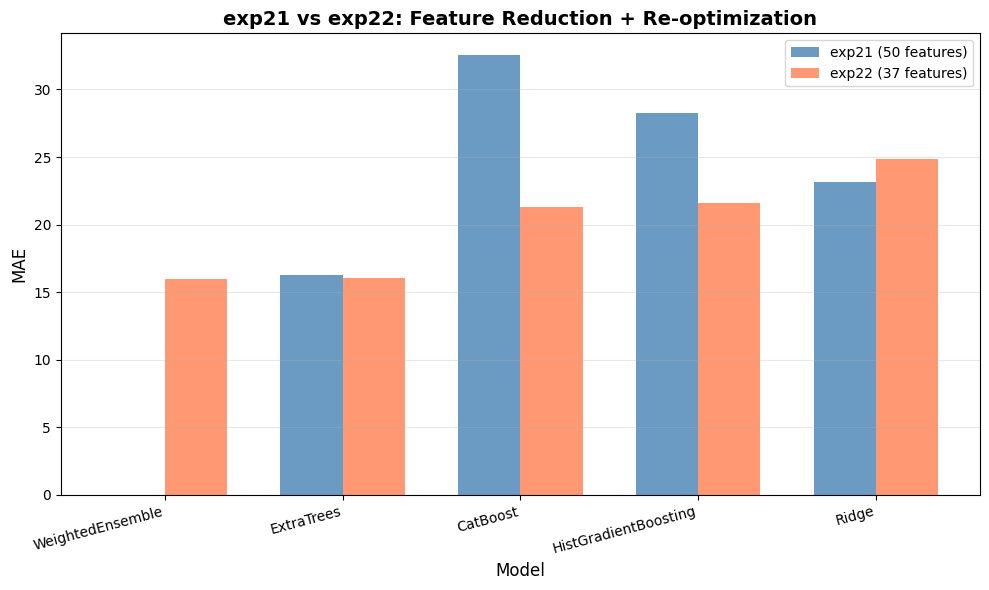


保存しました: ../output/exp22/exp21_vs_exp22_comparison.csv


In [21]:
# ==================================================================================
# exp21との比較
# ==================================================================================

import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("exp21 vs exp22 比較")
print("=" * 80)

# exp21の結果を読み込み
exp21_path = '../output/exp21/holdout_results.csv'
if os.path.exists(exp21_path):
    exp21_df = pd.read_csv(exp21_path)
    
    # 比較表を作成
    comparison_data = []
    for model in final_df['model'].unique():
        exp22_mae = final_df[final_df['model'] == model]['MAE'].values[0]
        exp21_mae = exp21_df[exp21_df['model'] == model]['MAE'].values[0] if model in exp21_df['model'].values else np.nan
        
        comparison_data.append({
            'model': model,
            'exp21_MAE (50 features)': exp21_mae,
            'exp22_MAE (37 features)': exp22_mae,
            'improvement': exp21_mae - exp22_mae if not np.isnan(exp21_mae) else np.nan
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))
    
    # 可視化
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = comparison_df['model'].tolist()
    x = np.arange(len(models))
    width = 0.35
    
    exp21_maes = comparison_df['exp21_MAE (50 features)'].fillna(0).tolist()
    exp22_maes = comparison_df['exp22_MAE (37 features)'].tolist()
    
    bars1 = ax.bar(x - width/2, exp21_maes, width, label='exp21 (50 features)', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, exp22_maes, width, label='exp22 (37 features)', color='coral', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('exp21 vs exp22: Feature Reduction + Re-optimization', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/exp21_vs_exp22_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    comparison_df.to_csv(f'{output_dir}/exp21_vs_exp22_comparison.csv', index=False)
    print(f"\n保存しました: {output_dir}/exp21_vs_exp22_comparison.csv")
else:
    print("exp21の結果ファイルが見つかりません。")


特徴量重要度分析（exp22最適化モデル）

HistGradientBoostingのPermutation Importance計算中...

【ExtraTrees】Top 10
                feature  ExtraTrees
day_before_holiday_flag    0.406773
                   ma_7    0.123733
               ma_std_7    0.102482
               acc_ma_7    0.090206
         is_rush_period    0.057110
            acc_get_cnt    0.038431
              ma_std_30    0.027852
               ma_std_3    0.026689
                  lag_1    0.017975
                  ma_30    0.017776

【HistGradientBoosting】Top 10
                feature  HistGradientBoosting
day_before_holiday_flag              1.715743
                  ma_30              0.016827
             search_cnt              0.011301
                 cm_flg              0.007681
               ma_std_7              0.005943
                  lag_2              0.001977
                  cm_7d              0.001374
               ma_std_3              0.001149
                dow_avg              0.000933
                gt_m

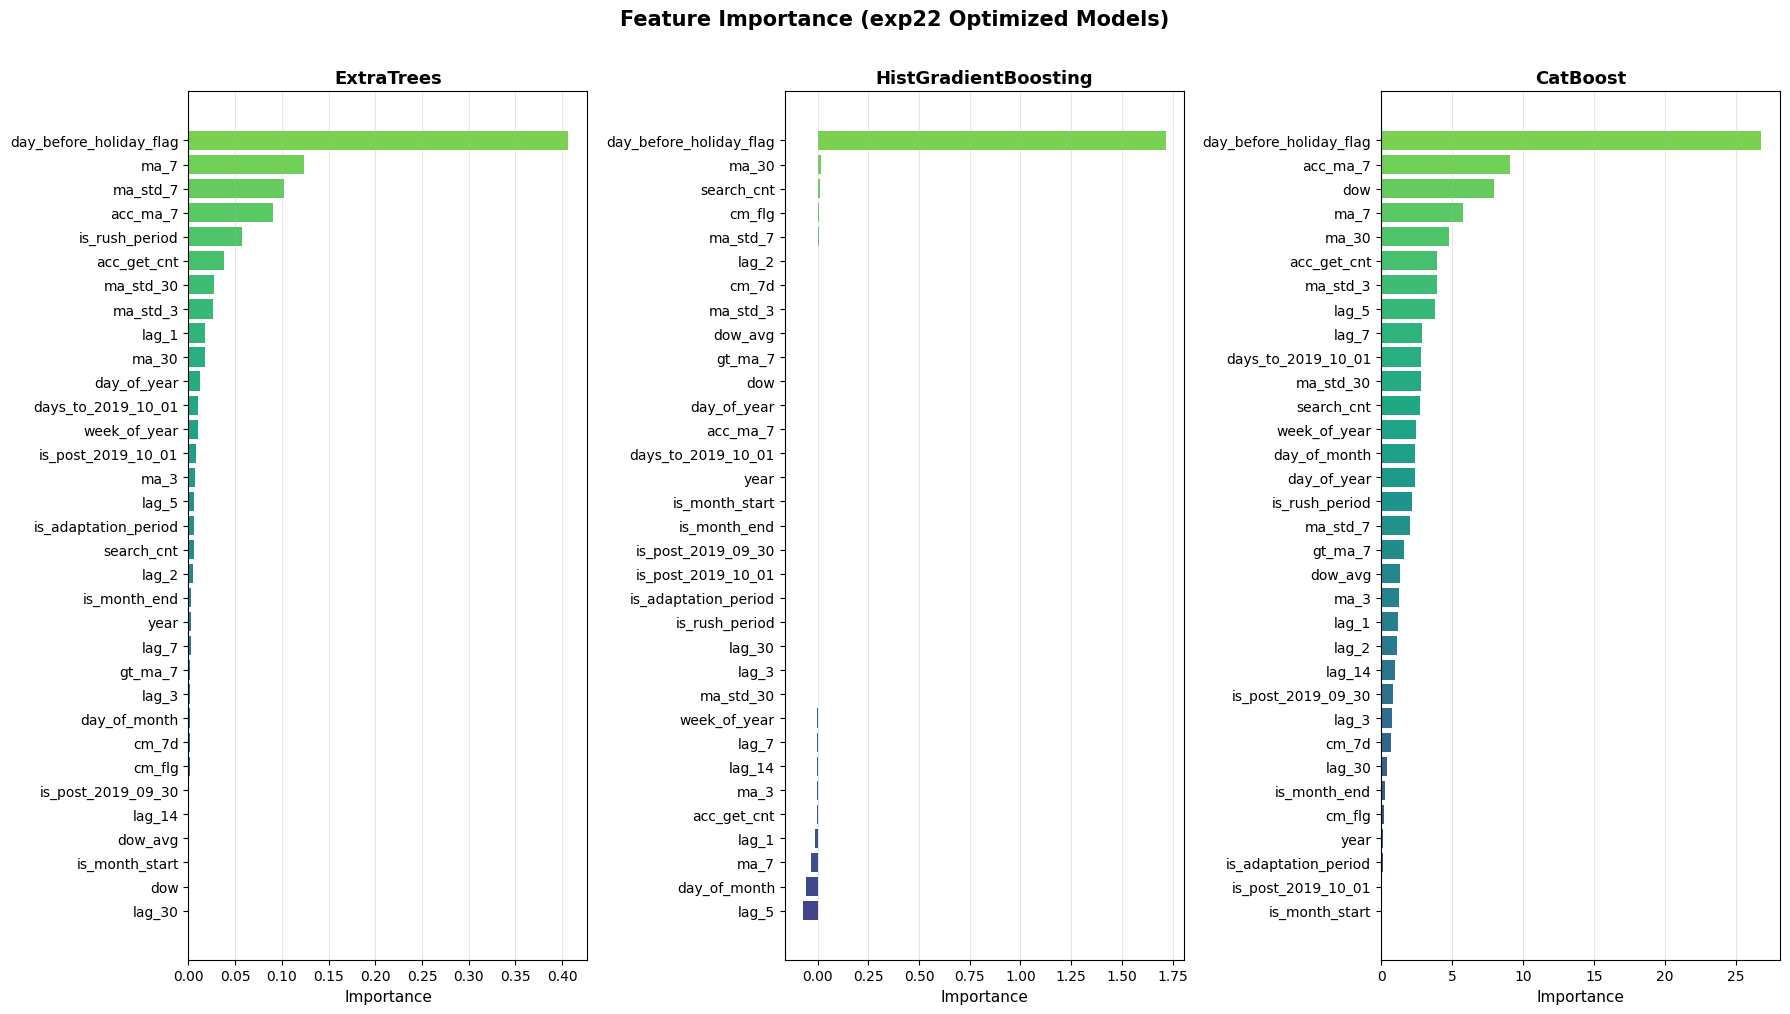


保存しました: ../output/exp22/feature_importance.csv


In [22]:
# ==================================================================================
# 特徴量重要度分析（最適化後モデル）
# ==================================================================================

from sklearn.inspection import permutation_importance

print("\n" + "=" * 80)
print("特徴量重要度分析（exp22最適化モデル）")
print("=" * 80)

# 各モデルの特徴量重要度
importance_data = {}

# ExtraTrees
importance_data['ExtraTrees'] = extra_opt.feature_importances_

# CatBoost
importance_data['CatBoost'] = catboost_opt.feature_importances_

# HistGradientBoosting (permutation importance)
print("\nHistGradientBoostingのPermutation Importance計算中...")
perm_importance = permutation_importance(hist_opt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_data['HistGradientBoosting'] = perm_importance.importances_mean

# DataFrameにまとめる
importance_df = pd.DataFrame({
    'feature': feature_cols_exp22,
    'ExtraTrees': importance_data['ExtraTrees'],
    'HistGradientBoosting': importance_data['HistGradientBoosting'],
    'CatBoost': importance_data['CatBoost']
})

# 各モデルの重要度を表示
for model_name in ['ExtraTrees', 'HistGradientBoosting', 'CatBoost']:
    print(f"\n【{model_name}】Top 10")
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=False).head(10)
    print(sorted_df.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for idx, model_name in enumerate(['ExtraTrees', 'HistGradientBoosting', 'CatBoost']):
    ax = axes[idx]
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=True)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_df)))
    ax.barh(sorted_df['feature'], sorted_df[model_name], color=colors)
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

plt.suptitle('Feature Importance (exp22 Optimized Models)', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

importance_df.to_csv(f'{output_dir}/feature_importance.csv', index=False)
print(f"\n保存しました: {output_dir}/feature_importance.csv")

In [23]:
# ==================================================================================
# 最終結果の保存
# ==================================================================================

final_df.to_csv(f'{output_dir}/final_results.csv', index=False)

print("\n" + "=" * 80)
print("exp22 最終結果")
print("=" * 80)
print(final_df.to_string(index=False))

print(f"\n保存しました: {output_dir}/final_results.csv")


exp22 最終結果
               model       MAE      RMSE       R2      WAPE
    WeightedEnsemble 16.011169 21.521887 0.867084 16.690431
          ExtraTrees 16.035873 21.766129 0.864051 16.716183
            CatBoost 21.278076 27.867110 0.777157 22.180782
HistGradientBoosting 21.627301 32.517112 0.696584 22.544823
               Ridge 24.840729 30.726674 0.729077 25.894578

保存しました: ../output/exp22/final_results.csv


---

## Summary

**exp22: 冗長な特徴量の削減 + Optuna再最適化**

### 特徴量の削減（50 → 37）
| グループ | 削除 | 残す | 理由 |
|---------|------|------|------|
| 1 | woy | week_of_year | 名称統一 |
| 2 | days_from_start, days_to_2019_09_30 | days_to_2019_10_01 | PoC向け |
| 3/4 | is_pre_* | is_post_* | 冗長（pre = 1 - post） |
| 5 | quarter, month | day_of_year | 季節性の高粒度表現 |
| 6 | wom | day_of_month | CatBoostで強い |
| 7 | acc_get_lag7, acc_get_sum_14d | acc_ma_7 | 滑らかで扱いやすい |
| 9 | ma_14, ma_std_14 | ma_7, ma_std_7 | 短期が強い |

### 実験内容
1. **ベースライン**: exp19パラメータ + 特徴量削減
2. **Optuna最適化**: 各モデル100トライアル、TimeSeriesCV(n_splits=3)
3. **最終評価**: Holdout Test（exp21と同じ期間）

### 出力ファイル
1. `optimized_params.csv` - 最適化パラメータ
2. `final_results.csv` - 最終結果
3. `exp21_vs_exp22_comparison.csv` - exp21との比較
4. `feature_importance.csv` - 特徴量重要度


特徴量重要度分析（CatBoost最適化モデル）

【CatBoost】Top 20
                feature  CatBoost
day_before_holiday_flag 26.784787
               acc_ma_7  9.088275
                    dow  7.972089
                   ma_7  5.775659
                  ma_30  4.763147
            acc_get_cnt  3.976789
               ma_std_3  3.912434
                  lag_5  3.818923
                  lag_7  2.908501
     days_to_2019_10_01  2.795335
              ma_std_30  2.791693
             search_cnt  2.740918
           week_of_year  2.478366
           day_of_month  2.389989
            day_of_year  2.371231
         is_rush_period  2.209689
               ma_std_7  2.037984
                gt_ma_7  1.596717
                dow_avg  1.358715
                   ma_3  1.276155


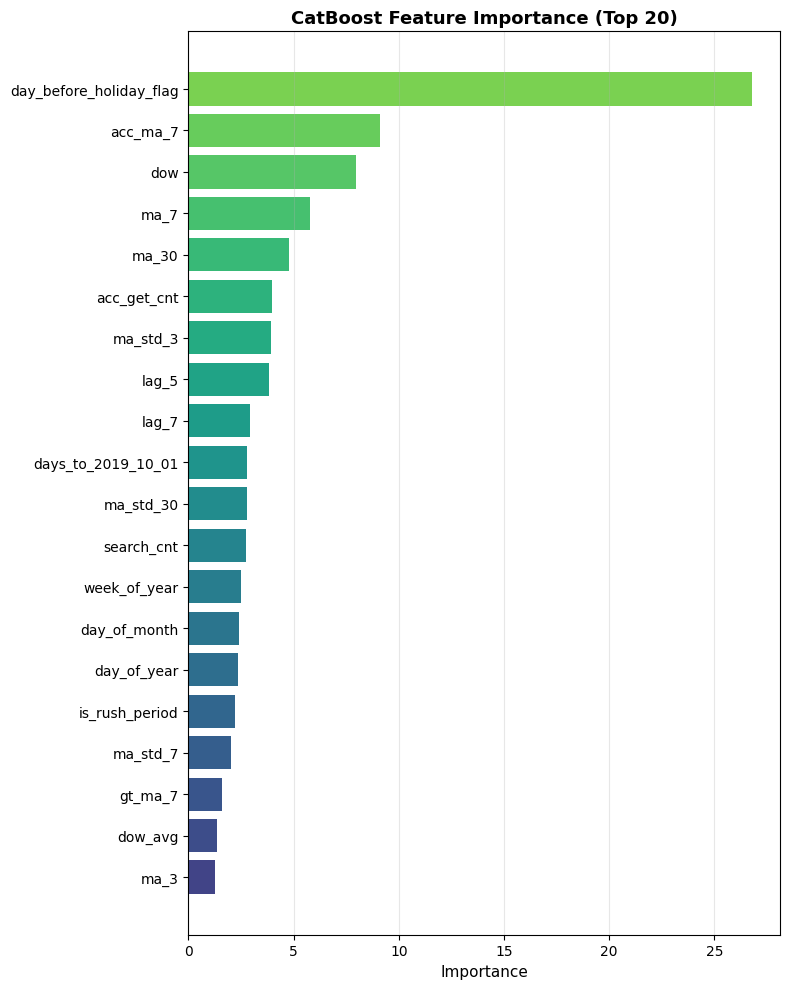


保存しました: ../output/exp22/feature_importance_catboost.csv


In [27]:
# ==================================================================================
# 特徴量重要度分析（CatBoostのみ）
# ==================================================================================
import pandas as pd
print("\n" + "=" * 80)
print("特徴量重要度分析（CatBoost最適化モデル）")
print("=" * 80)

# CatBoostの特徴量重要度
importance_df = pd.DataFrame({
    'feature': feature_cols_exp22,
    'CatBoost': catboost_opt.feature_importances_
})

# Top 20表示
print("\n【CatBoost】Top 20")
top20 = importance_df.sort_values('CatBoost', ascending=False).head(20)
print(top20.to_string(index=False))

# Top 20のみ可視化
plt.figure(figsize=(8, 10))
sorted_top20 = top20.sort_values('CatBoost', ascending=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_top20)))
plt.barh(sorted_top20['feature'], sorted_top20['CatBoost'], color=colors)
plt.xlabel('Importance', fontsize=11)
plt.title('CatBoost Feature Importance (Top 20)', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance_catboost_top20.png', dpi=300, bbox_inches='tight')
plt.show()

importance_df.to_csv(f'{output_dir}/feature_importance_catboost.csv', index=False)
print(f"\n保存しました: {output_dir}/feature_importance_catboost.csv")


In [25]:
# feature_cols_exp22 が未定義なら feature_cols_exp22 を作る
try:
    feature_cols_exp22
except NameError:
    feature_cols_exp22 = X_train.columns.tolist()



In [28]:
# 詳細メトリクス出力
def print_metric_details(y_true, y_pred, label=""):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    abs_err = np.abs(y_true - y_pred)
    abs_true = np.abs(y_true)

    n = len(y_true)
    sum_abs_err = abs_err.sum()
    sum_abs_true = abs_true.sum()

    mae = sum_abs_err / n
    wape = (sum_abs_err / sum_abs_true) * 100 if sum_abs_true != 0 else np.nan

    print(f"\n[{label}]")
    print(f"N (母数, MAE): {n}")
    print(f"Σ|y_true - y_pred| (WAPE分子): {sum_abs_err:.6f}")
    print(f"Σ|y_true| (WAPE母数): {sum_abs_true:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"WAPE(%): {wape:.6f}")

# 例: モデル評価後に呼び出し
print_metric_details(y_test, y_pred, label="Ridge Opt")


NameError: name 'y_pred' is not defined